In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.measure import block_reduce
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
in_dir = 'dataset2-master/dataset2-master/images'

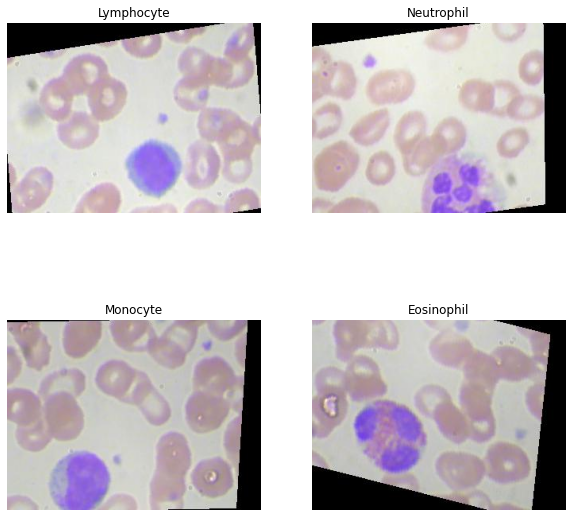

<Figure size 864x576 with 0 Axes>

In [3]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
def plotImage(h,w,image_path,title):
    image = cv2.imread(image_path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    axes[w,h].imshow(image)
    axes[w,h].axis('off')
    axes[w,h].set_title(title)
    
plt.figure(figsize=(12,8))
lymp_path = os.path.join(in_dir, 'TRAIN/LYMPHOCYTE') 
mono_path = os.path.join(in_dir, 'TRAIN/MONOCYTE')
neu_path = os.path.join(in_dir, 'TRAIN/NEUTROPHIL')
eos_path = os.path.join(in_dir, 'TRAIN/EOSINOPHIL')
plotImage(0,0,os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),'Lymphocyte')
plotImage(0,1,os.path.join(mono_path, random.choice(os.listdir(mono_path))),'Monocyte')
plotImage(1,0,os.path.join(neu_path, random.choice(os.listdir(neu_path))),'Neutrophil')
plotImage(1,1,os.path.join(eos_path, random.choice(os.listdir(eos_path))),'Eosinophil')
plt.tight_layout()
plt.show()

Total Train samples: 9957

Total Test samples: 2487



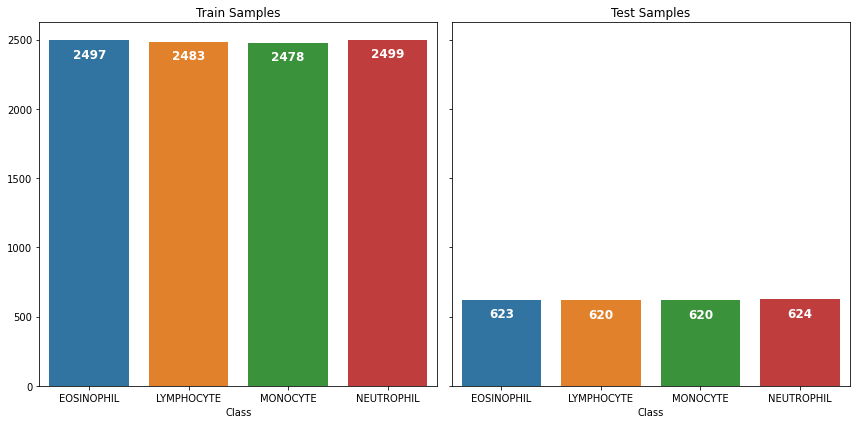

In [5]:
train_dir = os.path.join(in_dir, "TRAIN")
test_dir = os.path.join(in_dir, "TEST")
num_samples = 0
def plot_num_samples(path, s, ax):
    x = []
    y = []
    num_samples = 0
    for cls in os.listdir(path):
        num_imgs = len(os.listdir(os.path.join(path, cls)))
        num_samples += num_imgs
        x.append(cls)
        y.append(num_imgs)

    print('Total ' + s + ' samples: {:d}\n'.format(num_samples))
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_xlabel('Class')
    ax.set_title(s + ' Samples')
    for index, value in enumerate(y):
        ax.text(index, value-150, str(value), ha='center', va='bottom', color='white',weight='bold', fontsize=12)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
plot_num_samples(train_dir, "Train", ax1)
plot_num_samples(test_dir, "Test", ax2)
plt.tight_layout()
plt.show()

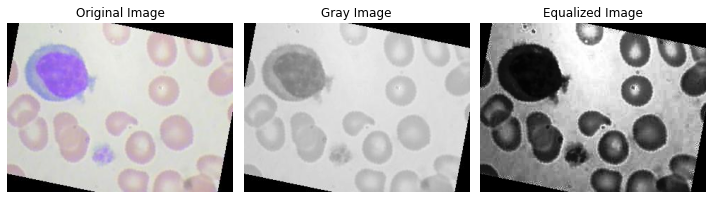

In [6]:
random_file = random.choice(os.listdir(lymp_path))
image = cv2.imread(os.path.join(lymp_path, random_file), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join(lymp_path, random_file))
image2 = image2[:, :, [2, 1, 0]]


# Perform histogram equalization
equalized_image = cv2.equalizeHist(image)
# Display the original and equalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image2)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')


plt.tight_layout()
plt.show()

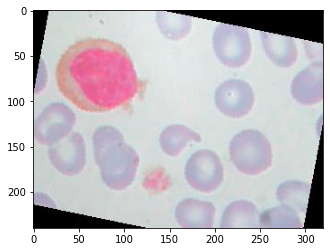

In [7]:
image3 = cv2.imread(os.path.join(lymp_path, random_file))
image3 = np.array(image3)
image3 = image3.astype(float) / 255

plt.imshow(image3)

In [8]:
def read_resize_img(path):
    image = cv2.imread(path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    resized_image = cv2.resize(image, (160,120))
    return resized_image

In [149]:
def create_sub_df(directory_path,num_cls):
    images = np.ndarray((len(os.listdir(directory_path)),120*160*3), dtype=np.uint8)
    i=0
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        resized_image = read_resize_img(file_path)
        images[i,:] = resized_image.ravel()
        i+=1
    df = pd.DataFrame(images)
    df["target"] = num_cls
    return df

def create_df(directory_path):
    clss = []
    for cls in os.listdir(directory_path):
        if str(cls) == "MONOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),0))
        elif str(cls) == "LYMPHOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),1))
        elif str(cls) == "NEUTROPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),2))
        elif str(cls) == "EOSINOPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),3))
    df = pd.concat(clss)
    return shuffle(df).reset_index(drop=True)

In [150]:
df_train = create_df(train_dir)
df_test = create_df(test_dir)

In [68]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,target
0,205,203,191,203,198,189,194,183,181,180,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,182,165,176,199,186,186,205,198,188,201,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,213,216,209,207,208,202,208,209,203,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,0,0,0,0,0,0,0,0,0,0,...,191,173,186,184,166,182,177,160,178,3
9953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9955,188,188,199,188,188,198,188,188,195,185,...,0,0,0,0,0,0,0,0,0,4


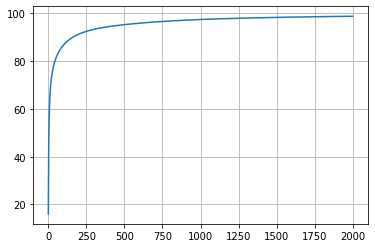

In [75]:
pca = PCA(n_components=2000)
pca.fit(df_train)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.savefig('pca.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


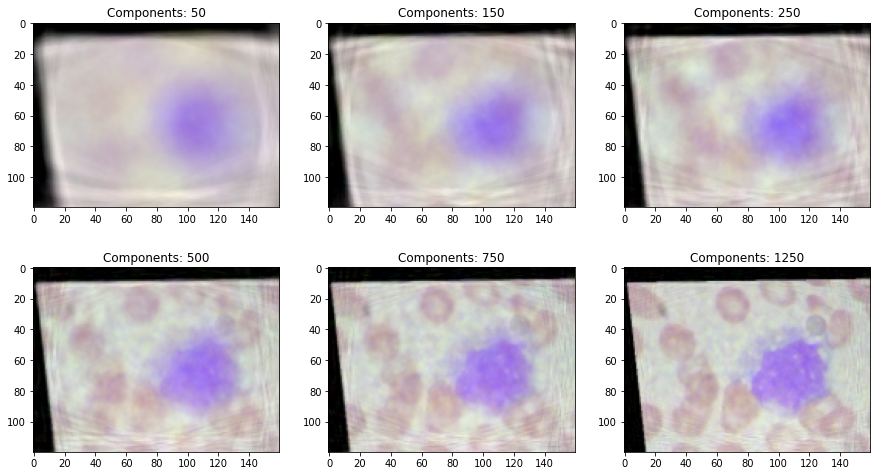

In [69]:
def plot_at_k(k):
    pca = PCA(n_components=k)
    x = mono_train.iloc[:, :-1]
#     print(np.array(x.iloc[2, :]))
    x = x.astype(float) / 255
    x = pca.fit_transform(x)         
    dff = pd.DataFrame(pca.inverse_transform(x))
#     print(np.array(dff.iloc[2, :]))
    plt.imshow(np.array(dff.iloc[2, :]).reshape((120, 160, 3)))


ks = [50, 150, 250,500,750,1250]

plt.figure(figsize=[15, 9])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plot_at_k(ks[i])
    plt.title("Components: " + str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()
# first_row

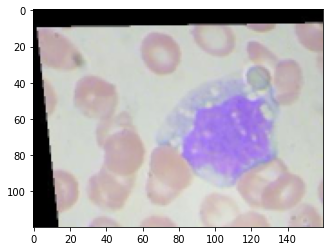

In [140]:
plt.imshow(np.array(mono_train.iloc[2, :-1]).reshape((120, 160, 3)))


In [110]:
pca = PCA(n_components=2000)
df_train_reconstructed_pca = pca.inverse_transform(pca.fit_transform(df_train.iloc[:, :-1]))
df_test_reconstructed_pca = pca.inverse_transform(pca.transform(df_test.iloc[:, :-1]))

In [114]:
df_train_reconstructed_pca = pd.DataFrame(df_train_reconstructed_pca)
df_test_reconstructed_pca = pd.DataFrame(df_test_reconstructed_pca)

In [121]:
def max_pooling(df):
    max_pool_df = pd.DataFrame()  # Empty DataFrame to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160, 3)
        max_pool = block_reduce(img, block_size=(5, 5, 1), func=np.max)
        ravel_img = max_pool.ravel()

        # Append pooled image as a row to max_pool_df
        max_pool_df = max_pool_df.append(pd.Series(ravel_img), ignore_index=True)
        
    return max_pool_df
    

In [71]:
max_m = max_pooling(mono_train).astype('uint8')
max_l = max_pooling(lymp_train).astype('uint8')

(-0.5, 31.5, 23.5, -0.5)

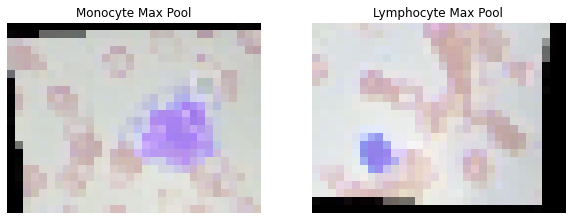

In [74]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(max_m.iloc[2, :-1]).reshape(24, 32, 3))
plt.title('Monocyte Max Pool')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.array(max_l.iloc[2, :-1]).reshape(24, 32, 3))
plt.title('Lymphocyte Max Pool')
plt.axis('off')

In [122]:
df_train_max_poll = max_pooling(pd.DataFrame(df_train_reconstructed_pca))
df_test_max_poll = max_pooling(pd.DataFrame(df_test_reconstructed_pca))

Text(0.5, 1.0, '1.8601804555905268')

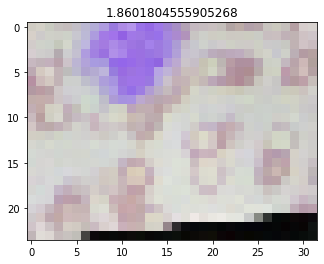

In [88]:
img = df_train_max_poll.iloc[2, :-1] / 255

plt.imshow(np.array(img).reshape(24, 32, 3))
plt.title(df_train_max_poll.iloc[2, -1])

In [124]:
df_train_max_poll = df_train_max_poll.join(df_train.iloc[:, -1])
df_test_max_poll = df_test_max_poll.join(df_test.iloc[:, -1])

In [126]:
df_train_max_poll.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv', index=False)
df_test_max_poll.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv', index=False)

In [2]:
df_train_max_poll = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv')
df_test_max_poll = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv')

# Models


In [3]:
X_train, y_train = df_train_max_poll.iloc[:, :-1], df_train_max_poll.iloc[:, -1]
X_test, y_test = df_test_max_poll.iloc[:, :-1], df_test_max_poll.iloc[:, -1]

In [4]:
df_train_max_poll

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,target
0,213.927856,201.505630,199.785072,212.042538,194.290631,193.201697,200.104004,183.243434,181.337762,185.608974,...,24.708316,27.876630,28.384156,14.475192,12.630548,13.405411,10.311603,10.544174,9.762943,2
1,10.451947,10.648147,7.460923,173.530462,167.593483,168.836917,224.313858,221.010827,217.026901,206.469831,...,7.771059,9.649631,5.458064,6.655407,11.012748,9.245616,17.676291,21.470518,20.570924,3
2,209.914682,203.937682,196.559067,211.365483,209.542925,202.451368,208.412971,207.055897,200.765399,201.400440,...,6.004455,8.888206,10.650558,9.667785,12.010202,10.787807,10.248925,13.565562,12.594568,1
3,15.778543,18.198164,13.247783,5.143325,10.382363,7.297202,4.248349,12.164793,6.020629,18.496854,...,207.203325,207.189738,200.061212,188.729350,187.138494,183.438974,120.202385,118.914883,121.364772,2
4,9.981002,10.961536,8.923553,6.184986,6.332098,5.063374,10.967024,14.872974,11.862715,6.048618,...,226.203549,224.357756,228.363317,225.266482,225.628721,218.243441,225.350551,226.073236,215.124520,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,7.094290,6.475522,10.865129,10.446786,9.697138,14.847230,7.334858,7.793813,11.380058,11.389491,...,211.207263,210.508903,201.893906,203.609963,204.845827,198.486105,194.398412,188.353700,189.093345,3
9953,7.916909,5.997268,5.868418,12.347532,10.961828,7.180793,8.188294,5.394987,5.390001,6.772056,...,6.350224,10.645470,7.519439,7.753761,11.707059,14.086170,5.419818,7.025313,10.466441,1
9954,12.049410,6.607852,11.028860,10.461475,6.831324,7.480618,9.330502,7.255613,6.529084,7.281557,...,7.181734,7.858839,10.645139,5.409923,7.737677,9.058065,3.746487,5.740539,8.430655,2
9955,195.493124,194.899229,193.138593,202.047728,200.941293,203.842019,199.723568,195.280348,191.257244,200.760202,...,105.194533,96.835362,98.578402,7.961119,5.624381,5.508895,7.000309,3.313445,3.989799,4


In [5]:
k_range = list(range(1, 14, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

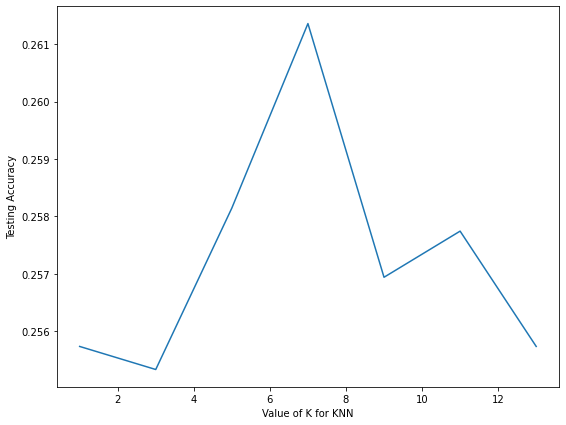

In [6]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

Training Accuracy : 0.49201566736968966
Testing Accuracy : 0.26135906714917573

              precision    recall  f1-score   support

           1       0.26      0.35      0.30       620
           2       0.28      0.19      0.22       620
           3       0.27      0.33      0.30       624
           4       0.23      0.17      0.19       623

    accuracy                           0.26      2487
   macro avg       0.26      0.26      0.25      2487
weighted avg       0.26      0.26      0.25      2487



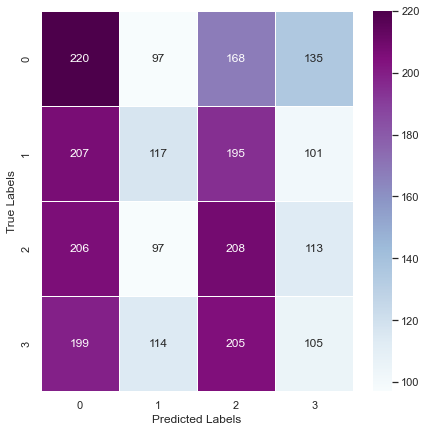

In [7]:
results={}

def HetmapAndConf(model , X_train , y_train , X_test, y_test):
    #training the model
    model.fit(X_train,y_train)
    #model prediction
    y_pred = model.predict(X_test)
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=True , cmap="BuPu", linewidths=1, fmt = 'd')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    # add accuracy score to 'results'
    results[model]=metrics.accuracy_score(y_test, y_pred)
    # evaluating the model
    print("Training Accuracy :", model.score(X_train, y_train))
    print("Testing Accuracy :" , metrics.accuracy_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
HetmapAndConf(KNeighborsClassifier(n_neighbors=7) , X_train , y_train , X_test, y_test)

In [9]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.7025208396103244
Testing Accuracy : 0.39525532770406113

              precision    recall  f1-score   support

           1       0.53      0.58      0.55       620
           2       0.44      0.34      0.38       620
           3       0.31      0.35      0.33       624
           4       0.31      0.31      0.31       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.39      2487
weighted avg       0.40      0.40      0.39      2487



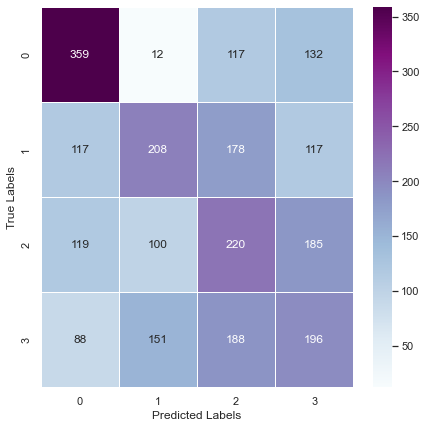

In [18]:
HetmapAndConf(LogisticRegression(max_iter=200) , X_train_std , y_train , X_test_std, y_test)

In [146]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(120,160, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 118, 158, 64)      1792      
                                                                 
 batch_normalization_9 (Batc  (None, 118, 158, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 79, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 77, 128)       73856     
                                                                 
 batch_normalization_10 (Bat  (None, 57, 77, 128)      512       
 chNormalization)                                                
                                                      

In [152]:
X_train_s, y_train_s = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_test_s, y_test_s = df_test.iloc[:, :-1], df_test.iloc[:, -1]
reshaped_X_train_s = X_train_s.to_numpy().reshape((9957, 120, 160, 3))
reshaped_X_test_s = X_test_s.to_numpy().reshape((2487, 120, 160, 3))

In [154]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(reshaped_X_train_s, y_train_s, epochs=10, batch_size=32,
                    validation_data=(reshaped_X_test_s, y_test_s))

Epoch 1/10
312/312 [==============================] - 1285s 4s/step - loss: 1.5287 - accuracy: 0.4629 - val_loss: 18.8312 - val_accuracy: 0.2505
Epoch 2/10
312/312 [==============================] - 1289s 4s/step - loss: 0.5242 - accuracy: 0.7975 - val_loss: 1.6345 - val_accuracy: 0.5734
Epoch 3/10
312/312 [==============================] - 1268s 4s/step - loss: 0.2586 - accuracy: 0.8970 - val_loss: 5.4777 - val_accuracy: 0.3796
Epoch 4/10
312/312 [==============================] - 1236s 4s/step - loss: 0.1447 - accuracy: 0.9460 - val_loss: 4.6913 - val_accuracy: 0.2891
Epoch 5/10
312/312 [==============================] - 1229s 4s/step - loss: 0.1524 - accuracy: 0.9447 - val_loss: 1.8279 - val_accuracy: 0.6357
Epoch 6/10
312/312 [==============================] - 1234s 4s/step - loss: 0.1030 - accuracy: 0.9647 - val_loss: 9.9290 - val_accuracy: 0.3341
Epoch 7/10
312/312 [==============================] - 1231s 4s/step - loss: 0.0991 - accuracy: 0.9638 - val_loss: 23.4652 - val_accurac

78/78 - 63s - loss: 5.5686 - accuracy: 0.4974 - 63s/epoch - 804ms/step


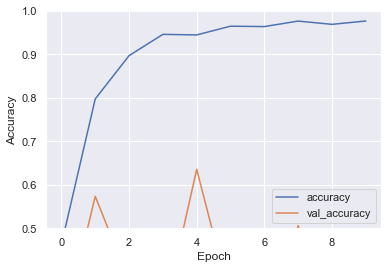

In [157]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(reshaped_X_test_s,  y_test_s, verbose=2)

In [158]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [168]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = 4
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=120,160
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(reshaped_X_train_s,y_train_s,reshaped_X_test_s,y_test_s,1)

MemoryError: Unable to allocate 2.14 GiB for an array with shape (9957, 120, 160, 3) and data type float32